In [1]:
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchrl.modules.distributions import MaskedCategorical
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Define env
from pettingzoo.classic import connect_four_v3
env = connect_four_v3.env()

Defining Classes

In [3]:
class ActorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, kernel_size=2), #Input 6x7 #Out 5x6
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=2), #In 5x6 #Out 4x5
            nn.Flatten(),
        )
        self.linear = nn.Sequential(
            nn.Linear(160,128), #8x4x5 -> 80
            nn.ReLU(),
            nn.Linear(128,7)
        )
    def forward(self, x):
        x = self.layer(x)
        x = self.linear(x)
        return x

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, mask, action, reward, next_state, next_mask, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, mask, action, reward, next_state, next_mask, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, mask, action, reward, next_state, next_mask, done = map(np.stack, zip(*batch))
        return state, mask, action, reward, next_state, next_mask, done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
class DQN:
    def __init__(self):
        self.q_network = ActorNet().to(device)
        self.opt_q = torch.optim.AdamW(self.q_network.parameters(), lr=0.001)
        self.replay_buffer_size = 10000000
        self.replay_buffer = ReplayBuffer(self.replay_buffer_size)
        self.MSE = torch.nn.MSELoss()
        self.batch_size = 128
        self.epsilon = 1/10
        
    def update(self):
        state, mask, action, reward, next_state, next_mask, termination = self.replay_buffer.sample(self.batch_size)
        state =  torch.tensor(state.reshape(-1, 2, 6,7)).to(device).float()
        next_state =  torch.tensor(next_state.reshape(-1, 2, 6, 7)).to(device).float()
        final_state_check = torch.tensor((1-termination)).to(device)
        reward = torch.tensor(reward).to(device)
        target = torch.max(self.q_network(next_state), dim=1)[0]
        target *= final_state_check
        target *= gamma
        target += reward
        #target = reward + final_state_check * gamma * torch.max(self.q_network(next_state), dim=1)[0]
        self.opt_q.zero_grad()
        loss = self.MSE(target, self.q_network(state)[torch.arange(self.batch_size), action])
        loss.backward()
        self.opt_q.step()
        return loss.item()
    
    def update_given_buffer(self, replay_buffer):
        state, mask, action, reward, next_state, next_mask, termination = replay_buffer.sample(self.batch_size)
        state =  torch.tensor(state.reshape(-1, 2, 6,7)).to(device).float()
        next_state =  torch.tensor(next_state.reshape(-1, 2, 6, 7)).to(device).float()
        final_state_check = torch.tensor((1-termination)).to(device)
        reward = torch.tensor(reward).to(device)
        target = torch.max(self.q_network(next_state), dim=1)[0]
        target *= final_state_check
        target *= gamma
        target += reward
        #target = reward + final_state_check * gamma * torch.max(self.q_network(next_state), dim=1)[0]
        self.opt_q.zero_grad()
        loss = self.MSE(target, self.q_network(state)[torch.arange(self.batch_size), action])
        loss.backward()
        self.opt_q.step()
        return loss.item()   
    
    def choose_action(self, state, greedy= False):
        mask = state["action_mask"]
        indices_of_ones = np.where(mask == 1)[0]
        action_random = np.random.choice(indices_of_ones)
        #mask = torch.BoolTensor(mask).to(device)
        mask = torch.tensor(np.where(mask==0, -np.infty, 0), dtype=torch.float32).to(device).float()
        #print(mask)
        state = torch.tensor(state['observation'].reshape(1, 2, 6, 7)).to(device).float()
        logits = self.q_network(state)
        #print(logits * mask)
        action_greedy = torch.argmax(mask + logits).tolist()
        if greedy:
            return action_greedy
        return np.random.choice([action_random, action_greedy], p=[self.epsilon, 1-self.epsilon])

# Train with Random Agents

In [6]:
agent_1 = DQN()

In [37]:
gamma = 1
returns = []
losses_agent1 = []
rewards_agent1 = []
greedy_agents = False
episodes = 10_000
#env = connect_four_v3.env(render_mode="human")
episode_lengths = []
for episode in tqdm(range(episodes)):
    env.reset()
    #p0
    observation_p0, reward, termination, truncation, info = env.last()
    env.step(env.action_space("player_0").sample(observation_p0["action_mask"]))
    #p1
    observation_p1, reward, termination, truncation, info = env.last()
    action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
    env.step(action_p1)
    #
    for agent in env.agent_iter():
        ######
        observation_p0_prime, reward, termination, truncation, info = env.last()
        #Update
        observation_p0 = observation_p0_prime
        #Choose action for player 0 
        if termination or truncation:
            #Update p1 and end
            env.step(None)
            observation_p1_prime, reward, termination, truncation, info = env.last()
            agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
            rewards_agent1+= [reward]
            break
        #
        env.step(env.action_space("player_0").sample(observation_p0["action_mask"]))
        ##################################################################
        observation_p1_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
        rewards_agent1+=[reward]
        observation_p1 = observation_p1_prime
        #Choose action for player 1
        if termination or truncation:
            #Update p0 and end
            env.step(None)
            break
        action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
        env.step(action_p1)
        #################
        if len(agent_1.replay_buffer) > agent_1.batch_size:
            loss = agent_1.update()
            losses_agent1 += [loss]
env.close()

100%|██████████| 10000/10000 [10:18<00:00, 16.16it/s]


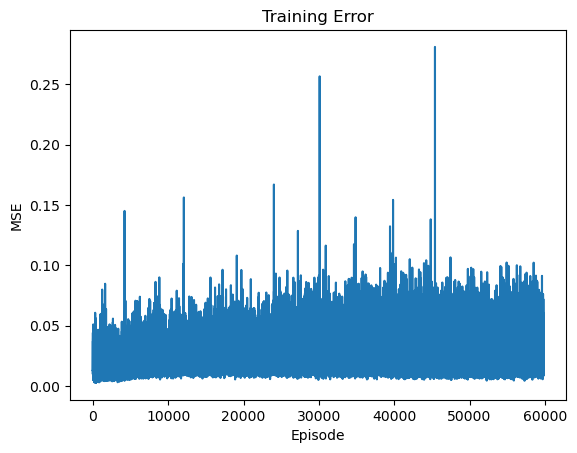

In [38]:
plt.plot(losses_agent1)
plt.xlabel("Episode")
plt.ylabel("MSE")
plt.title("Training Error")
plt.savefig("random_connect4_dqn.png", bbox_inches='tight')

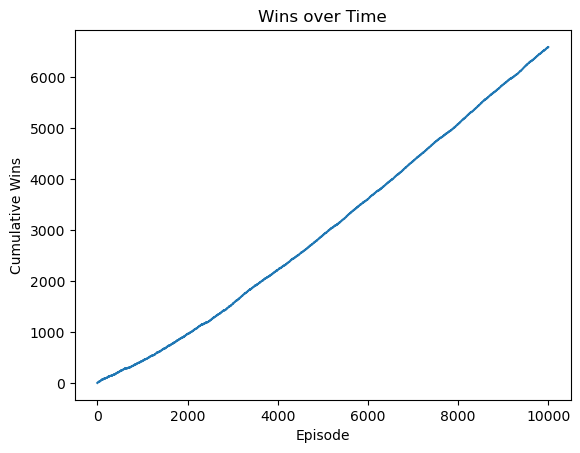

In [39]:
arr = [i for i in rewards_agent1 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("random_connect4_dqn_cumuWins.png", bbox_inches='tight')

# Train DQN Agents Against Each Other

In [16]:
agent_0 = DQN()
agent_1 = DQN()

In [7]:
gamma = 1
returns = []
losses_agent0 = []
losses_agent1 = []
rewards_agent0 = []
rewards_agent1 = []
greedy_agents = False
episodes = 50_000
#env = connect_four_v3.env(render_mode="human")
episode_lengths = []
for episode in tqdm(range(episodes)):
    env.reset()
    step = 2
    #p0
    observation_p0, reward, termination, truncation, info = env.last()
    action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
    env.step(action_p0)
    #p1
    observation_p1, reward, termination, truncation, info = env.last()
    action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
    env.step(action_p1)
    #
    for agent in env.agent_iter():
        step+=1
        ######
        observation_p0_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_0.replay_buffer.push(observation_p0["observation"], observation_p0["action_mask"], action_p0, reward, observation_p0_prime["observation"], observation_p0_prime["action_mask"], termination)
        rewards_agent0 += [reward]
        observation_p0 = observation_p0_prime
        #Choose action for player 0 
        if termination or truncation:
            #Update p1 and end
            env.step(None)
            observation_p1_prime, reward, termination, truncation, info = env.last()
            agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
            rewards_agent1+= [reward]
            break
        action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
        env.step(action_p0)
        ##################################################################
        observation_p1_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
        rewards_agent1+=[reward]
        observation_p1 = observation_p1_prime
        #Choose action for player 1
        if termination or truncation:
            #Update p0 and end
            env.step(None)
            observation_p0_prime, reward, termination, truncation, info = env.last()
            agent_0.replay_buffer.push(observation_p0["observation"], observation_p0["action_mask"], action_p0, reward, observation_p0_prime["observation"], observation_p0_prime["action_mask"], termination)
            rewards_agent0+=[reward]
            break
        action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
        env.step(action_p1)
        #################
        if len(agent_0.replay_buffer) > agent_0.batch_size:
            loss = agent_0.update()
            losses_agent0 += [loss]
        if len(agent_1.replay_buffer) > agent_1.batch_size:
            loss = agent_1.update()
            losses_agent1 += [loss]
    episode_lengths += [step]
env.close()

torch.save(agent_0.q_network.state_dict(), "./agent0_q_weights.pt")
torch.save(agent_1.q_network.state_dict(), "./agent1_q_weights.pt")

100%|██████████| 50000/50000 [2:35:06<00:00,  5.37it/s]  


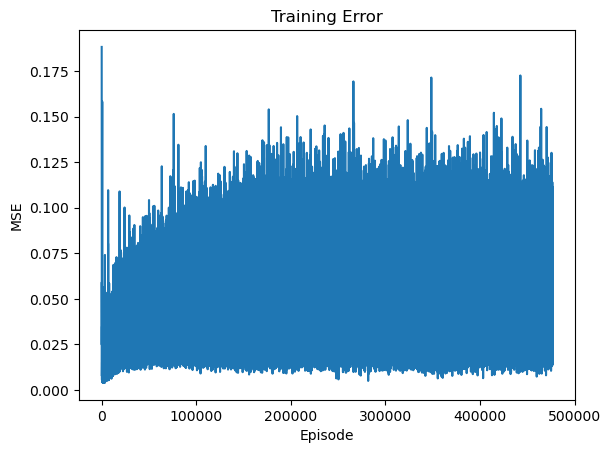

In [14]:
plt.plot(losses_agent0)
plt.xlabel("Episode")
plt.ylabel("MSE")
plt.title("Training Error")
plt.savefig("agent0_connect4_dqn.png", bbox_inches='tight')

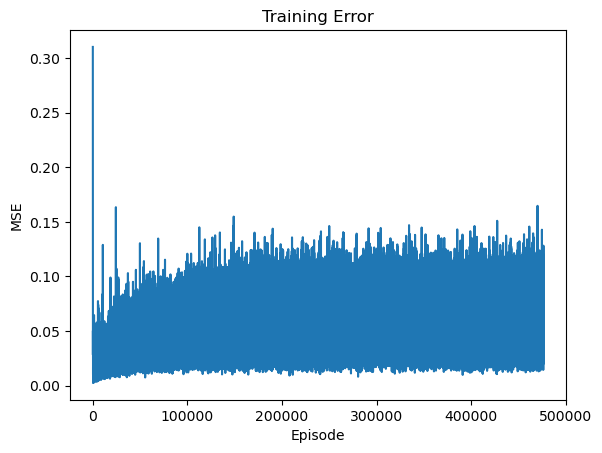

In [15]:
plt.plot(losses_agent1)
plt.xlabel("Episode")
plt.ylabel("MSE")
plt.title("Training Error")
plt.savefig("agent1_connect4_dqn.png", bbox_inches='tight')

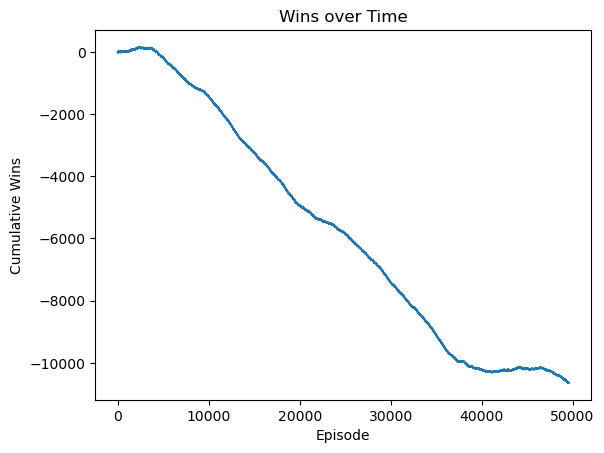

In [32]:
arr = [i for i in rewards_agent1 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent1_connect4_dqn_cumuWins.png", bbox_inches='tight')

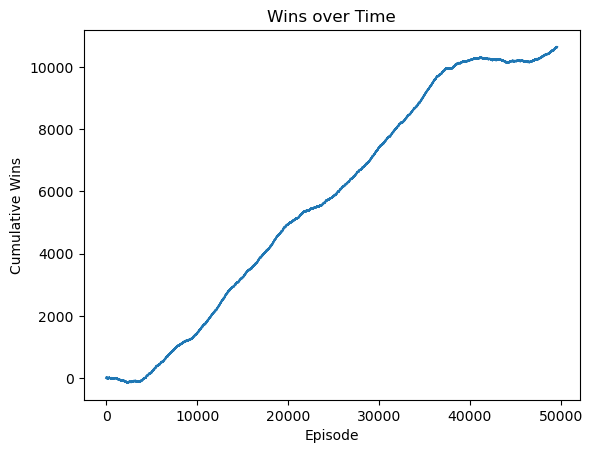

In [33]:
arr = [i for i in rewards_agent0 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent0_connect4_dqn_cumuWins.png", bbox_inches='tight')

# Now Train with Added Buffer for Key States


In [42]:
agent_0 = DQN()
agent_1 = DQN()
replay_buffer_size = 10000000
key_state_buffer_agent1 = ReplayBuffer(replay_buffer_size)

In [43]:
gamma = 1
returns = []
losses_agent0 = []
losses_agent1 = []
rewards_agent0 = []
rewards_agent1 = []
greedy_agents = False
episodes = 50_000
#env = connect_four_v3.env(render_mode="human")
episode_lengths = []
for episode in tqdm(range(episodes)):
    env.reset()
    step = 2
    #p0
    observation_p0, reward, termination, truncation, info = env.last()
    action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
    env.step(action_p0)
    #p1
    observation_p1, reward, termination, truncation, info = env.last()
    action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
    env.step(action_p1)
    #
    for agent in env.agent_iter():
        step+=1
        ######
        observation_p0_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_0.replay_buffer.push(observation_p0["observation"], observation_p0["action_mask"], action_p0, reward, observation_p0_prime["observation"], observation_p0_prime["action_mask"], termination)
        rewards_agent0 += [reward]
        observation_p0 = observation_p0_prime
        #Choose action for player 0 
        if termination or truncation:
            #Update p1 and end
            env.step(None)
            observation_p1_prime, reward, termination, truncation, info = env.last()
            agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
            key_state_buffer_agent1.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
            rewards_agent1+= [reward]
            break
        action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
        env.step(action_p0)
        ##################################################################
        observation_p1_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
        rewards_agent1+=[reward]
        observation_p1 = observation_p1_prime
        #Choose action for player 1
        if termination or truncation:
            #Update p0 and end
            env.step(None)
            observation_p0_prime, reward, termination, truncation, info = env.last()
            agent_0.replay_buffer.push(observation_p0["observation"], observation_p0["action_mask"], action_p0, reward, observation_p0_prime["observation"], observation_p0_prime["action_mask"], termination)
            rewards_agent0+=[reward]
            break
        action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
        env.step(action_p1)
        #################
        if len(agent_0.replay_buffer) > agent_0.batch_size:
            loss = agent_0.update()
            losses_agent0 += [loss]
        if len(agent_1.replay_buffer) > agent_1.batch_size:
            loss = agent_1.update()
            losses_agent1 += [loss]
        if len(key_state_buffer_agent1) > agent_1.batch_size:
            loss = agent_1.update_given_buffer(key_state_buffer_agent1)
            losses_agent1 += [loss]
    episode_lengths += [step]
env.close()

100%|██████████| 50000/50000 [3:28:11<00:00,  4.00it/s]  


In [47]:
len(agent_1.replay_buffer)

493496

In [46]:
len(key_state_buffer_agent1)

18926

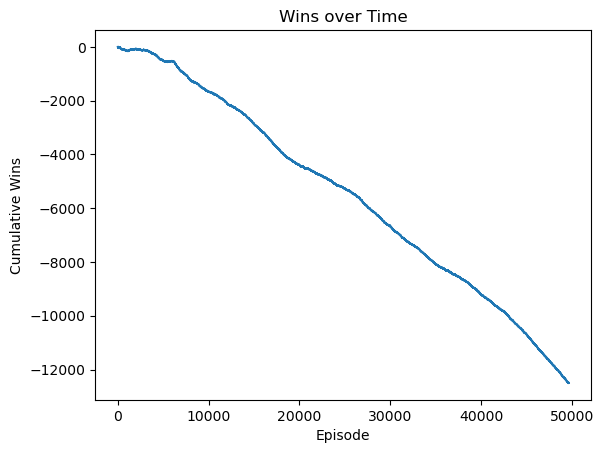

In [44]:
arr = [i for i in rewards_agent1 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent1_connect4_dqn_keyStateBuffer.png", bbox_inches='tight')

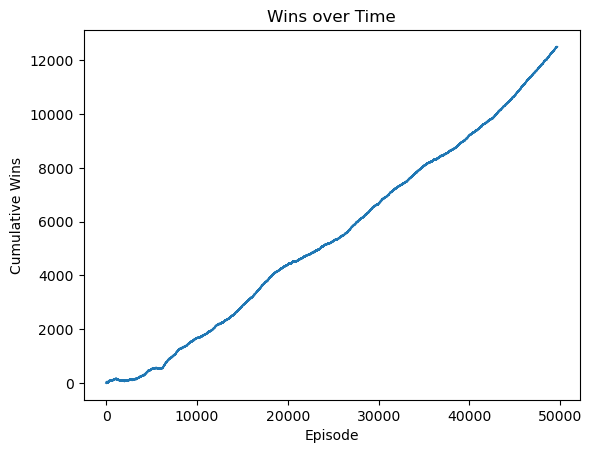

In [45]:
arr = [i for i in rewards_agent0 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent0_connect4_dqn_keyStateBuffer.png", bbox_inches='tight')

In [8]:
torch.save(agent_0.q_network.state_dict(), "./agent0_q_weights.pt")
torch.save(agent_1.q_network.state_dict(), "./agent1_q_weights.pt")

In [17]:
agent_0.q_network.load_state_dict(torch.load("./agent0_q_weights.pt"))
agent_1.q_network.load_state_dict(torch.load("./agent1_q_weights.pt"))

<All keys matched successfully>